# Импорт библиотек

In [1]:
import os
import warnings
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, roc_auc_score

warnings.filterwarnings('ignore')

# Чтение исходных данных

In [2]:
# путь до данных на компьютере
path = 'G:/ds-junior/final_work_ds/train_data'

In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                    num_parts_to_read: int = 12, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [4]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


        #здесь должен быть препроцессинг данных


        #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [5]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=12,
                                    save_to_path='G:/ds-junior/final_work_ds/train_data')

Transforming transactions data:   0%|          | 0/6 [00:00<?, ?it/s]

['G:/ds-junior/final_work_ds/train_data\\train_data_0.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_1.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_10.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_11.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_2.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_3.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_4.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_5.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_6.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_7.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_8.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_9.pq', 'G:/ds-junior/final_work_ds/train_data\\train_target.csv']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path G:/ds-junior/final_work_ds/train_data\train_data_0.pq
chunk_path G:/ds-junior/final_work_ds/train_data\train_data_1.pq
['G:/ds-junior/final_work_ds/train_data\\train_data_0.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_1.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_10.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_11.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_2.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_3.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_4.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_5.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_6.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_7.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_8.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_9.pq', 'G:/ds-junior/final_work_ds/train_data\\train_target.csv']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path G:/ds-junior/final_work_ds/train_data\train_data_10.pq
chunk_path G:/ds-junior/final_work_ds/train_data\train_data_11.pq
['G:/ds-junior/final_work_ds/train_data\\train_data_0.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_1.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_10.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_11.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_2.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_3.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_4.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_5.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_6.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_7.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_8.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_9.pq', 'G:/ds-junior/final_work_ds/train_data\\train_target.csv']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path G:/ds-junior/final_work_ds/train_data\train_data_2.pq
chunk_path G:/ds-junior/final_work_ds/train_data\train_data_3.pq
['G:/ds-junior/final_work_ds/train_data\\train_data_0.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_1.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_10.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_11.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_2.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_3.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_4.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_5.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_6.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_7.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_8.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_9.pq', 'G:/ds-junior/final_work_ds/train_data\\train_target.csv']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path G:/ds-junior/final_work_ds/train_data\train_data_4.pq
chunk_path G:/ds-junior/final_work_ds/train_data\train_data_5.pq
['G:/ds-junior/final_work_ds/train_data\\train_data_0.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_1.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_10.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_11.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_2.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_3.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_4.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_5.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_6.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_7.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_8.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_9.pq', 'G:/ds-junior/final_work_ds/train_data\\train_target.csv']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path G:/ds-junior/final_work_ds/train_data\train_data_6.pq
chunk_path G:/ds-junior/final_work_ds/train_data\train_data_7.pq
['G:/ds-junior/final_work_ds/train_data\\train_data_0.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_1.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_10.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_11.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_2.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_3.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_4.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_5.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_6.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_7.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_8.pq', 'G:/ds-junior/final_work_ds/train_data\\train_data_9.pq', 'G:/ds-junior/final_work_ds/train_data\\train_target.csv']


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

chunk_path G:/ds-junior/final_work_ds/train_data\train_data_8.pq
chunk_path G:/ds-junior/final_work_ds/train_data\train_data_9.pq


In [6]:
#пример полученных данных
pd.set_option('display.max_columns', None)
data.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,0,1,1,1,1,16,2,17,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0


# Объединение данных в датасет

In [7]:
# значения целевой переменной (смерджить с фичами по id)
targets = pd.read_csv('G:/ds-junior/final_work_ds/train_data/train_target.csv')
targets.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [8]:
data.shape

(26162717, 61)

In [9]:
targets.shape

(3000000, 2)

In [10]:
df = data.merge(targets, on='id')

In [11]:
df.shape

(26162717, 62)

# Описание признаков датасета

* id - Идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки.
* rn - Порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
* pre_since_opened - Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
* pre_since_confirmed	- Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
* pre_pterm - Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
* pre_fterm - Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
* pre_till_pclose - Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
* pre_till_fclose - Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
* pre_loans_credit_limit - Кредитный лимит (бинаризовано*)
* pre_loans_next_pay_summ - Сумма следующего платежа по кредиту (бинаризовано*)
* pre_loans_outstanding - Оставшаяся невыплаченная сумма кредита (бинаризовано*)
* pre_loans_total_overdue - Текущая просроченная задолженность (бинаризовано*)
* pre_loans_max_overdue_sum - Максимальная просроченная задолженность (бинаризовано*)
* pre_loans_credit_cost_rate - Полная стоимость кредита (бинаризовано*)
* pre_loans5 - Число просрочек до 5 дней (бинаризовано*)
* pre_loans530 - Число просрочек от 5 до 30 дней (бинаризовано*)
* pre_loans3060 - Число просрочек от 30 до 60 дней (бинаризовано*)
* pre_loans6090 - Число просрочек от 60 до 90 дней (бинаризовано*)
* pre_loans90	- Число просрочек более, чем на 90 дней (бинаризовано*)
* is_zero_loans_5	- Флаг: нет просрочек до 5 дней
* is_zero_loans_530 - Флаг: нет просрочек от 5 до 30 дней
* is_zero_loans_3060 - Флаг: нет просрочек от 30 до 60 дней
* is_zero_loans_6090 - Флаг: нет просрочек от 60 до 90 дней
* is_zero_loans90 - Флаг: нет просрочек более, чем на 90 дней
* pre_util - Отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*)
* pre_over2limit - Отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*)
* pre_maxover2limit - Отношенение максимальной просроченной задолженности к кредитному лимиту (бинаризовано*)
* is_zero_util - Флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равняется 0
* is_zero_over2limit - Флаг: отношение текущей просроченной задолженности к кредитному лимиту равняется 0
* is_zero_maxover2limit - Флаг: отношение максимальной просроченной задолженности к кредитному лимиту равняется 0
* enc_paym_{0..N} - Статусы ежемесячных платежей за последние N месяцев (закодировано**)
* enc_loans_account_holder_type - Тип отношения к кредиту (закодировано**)
* enc_loans_credit_status	- Статус кредита (закодировано**)
* enc_loans_account_cur - Валюта кредита (закодировано**)
* enc_loans_credit_type - Тип кредита (закодировано**)
* pclose_flag - Флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено
* fclose_flag - Флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено

* *область значений поля разбивается на N непересекающихся промежутков, каждому промежутку случайным образом ставится в соответствие уникальный номер от 0 до N-1, значение поля заменяется номером промежутка, которому оно принадлежит

* **каждому уникальному значению поля случайным образом ставится в соответствие уникальный номер от 0 до K, значение поля заменяется номером этого значения

# Информация о датасете

In [12]:
def convert_dtype(dtype):
    if dtype in ['int32', 'int64', 'int16', 'int8']:
        return 'int'
    elif dtype in ['float32', 'float64']:
        return 'float'
    return dtype

# Создаем список столбцов с типами данных
columns_with_types = [f"{col}: {convert_dtype(dtype.name)}" for col, dtype in df.dtypes.items()]

# Выводим список без кавычек
for item in columns_with_types:
    print(item)

id: int
rn: int
pre_since_opened: int
pre_since_confirmed: int
pre_pterm: int
pre_fterm: int
pre_till_pclose: int
pre_till_fclose: int
pre_loans_credit_limit: int
pre_loans_next_pay_summ: int
pre_loans_outstanding: int
pre_loans_total_overdue: int
pre_loans_max_overdue_sum: int
pre_loans_credit_cost_rate: int
pre_loans5: int
pre_loans530: int
pre_loans3060: int
pre_loans6090: int
pre_loans90: int
is_zero_loans5: int
is_zero_loans530: int
is_zero_loans3060: int
is_zero_loans6090: int
is_zero_loans90: int
pre_util: int
pre_over2limit: int
pre_maxover2limit: int
is_zero_util: int
is_zero_over2limit: int
is_zero_maxover2limit: int
enc_paym_0: int
enc_paym_1: int
enc_paym_2: int
enc_paym_3: int
enc_paym_4: int
enc_paym_5: int
enc_paym_6: int
enc_paym_7: int
enc_paym_8: int
enc_paym_9: int
enc_paym_10: int
enc_paym_11: int
enc_paym_12: int
enc_paym_13: int
enc_paym_14: int
enc_paym_15: int
enc_paym_16: int
enc_paym_17: int
enc_paym_18: int
enc_paym_19: int
enc_paym_20: int
enc_paym_21: int
e

In [13]:
# Посмотрим какая информация содержится в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 62 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19

In [14]:
# Проверим данные на пропуски
df.isna().sum()

id                       0
rn                       0
pre_since_opened         0
pre_since_confirmed      0
pre_pterm                0
                        ..
enc_loans_credit_type    0
enc_loans_account_cur    0
pclose_flag              0
fclose_flag              0
flag                     0
Length: 62, dtype: int64

In [15]:
# Пропусков нет

In [16]:
# Посмотрим описание датасета
# df.describe().round(2)

In [17]:
# Создаем функцию для подсчета уникальных значений в каждом признаке
def print_unique_count(df):
    for column in df.columns:
        unique_count = df[column].nunique()
        print(f"Признак: {column}")
        print(f"Количество уникальных значений: {unique_count}\n")

In [18]:
# Посмотрим количество уникальных значений в каждом признаке датасета
print_unique_count(df)

Признак: id
Количество уникальных значений: 3000000

Признак: rn
Количество уникальных значений: 58

Признак: pre_since_opened
Количество уникальных значений: 20

Признак: pre_since_confirmed
Количество уникальных значений: 18

Признак: pre_pterm
Количество уникальных значений: 18

Признак: pre_fterm
Количество уникальных значений: 17

Признак: pre_till_pclose
Количество уникальных значений: 17

Признак: pre_till_fclose
Количество уникальных значений: 16

Признак: pre_loans_credit_limit
Количество уникальных значений: 20

Признак: pre_loans_next_pay_summ
Количество уникальных значений: 7

Признак: pre_loans_outstanding
Количество уникальных значений: 5

Признак: pre_loans_total_overdue
Количество уникальных значений: 2

Признак: pre_loans_max_overdue_sum
Количество уникальных значений: 4

Признак: pre_loans_credit_cost_rate
Количество уникальных значений: 14

Признак: pre_loans5
Количество уникальных значений: 13

Признак: pre_loans530
Количество уникальных значений: 20

Признак: pre_l

# Визуализация значений признаков

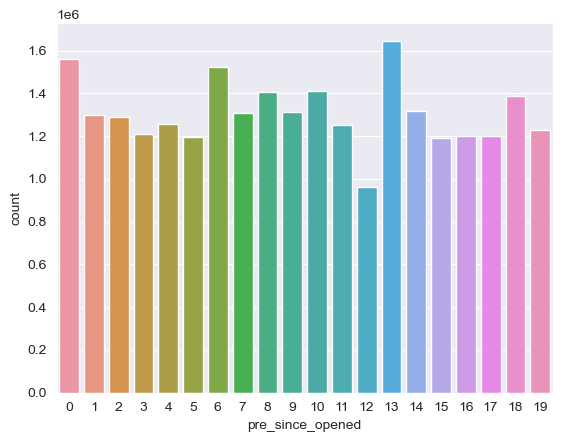

In [19]:
# pre_since_opened - Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
sns.countplot(x='pre_since_opened', data=df);

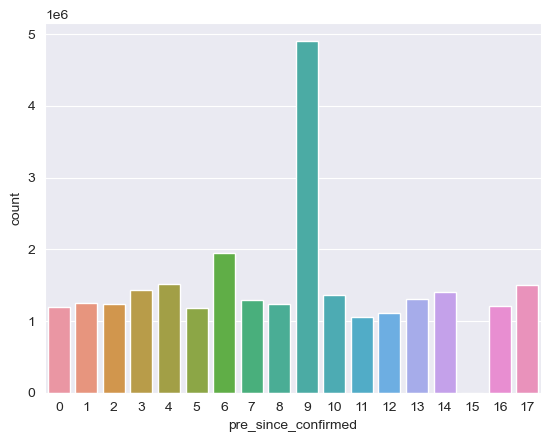

In [20]:
# pre_since_confirmed	- Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
sns.countplot(x='pre_since_confirmed', data=df);

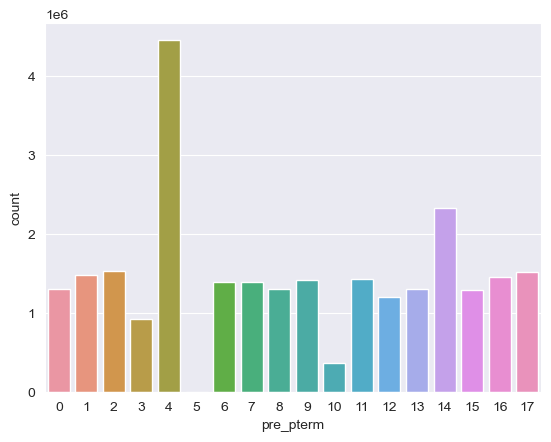

In [21]:
# pre_pterm - Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
sns.countplot(x='pre_pterm', data=df);

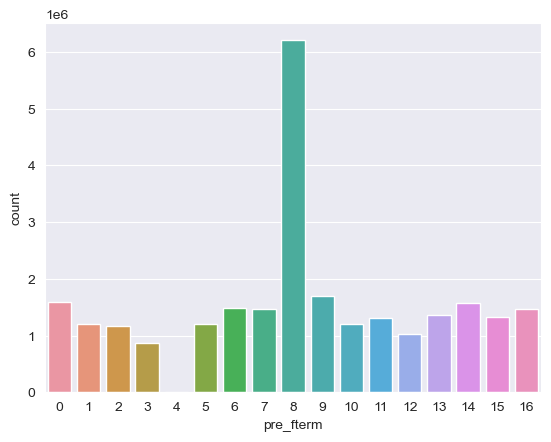

In [22]:
# pre_fterm - Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*) \
sns.countplot(x='pre_fterm', data=df);

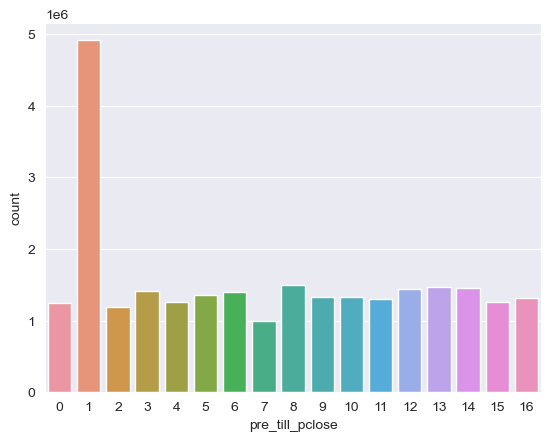

In [23]:
# pre_till_pclose - Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
sns.countplot(x='pre_till_pclose', data=df);

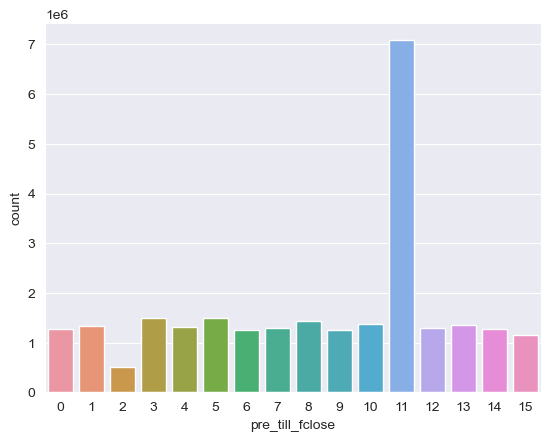

In [24]:
# pre_till_fclose - Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
sns.countplot(x='pre_till_fclose', data=df);

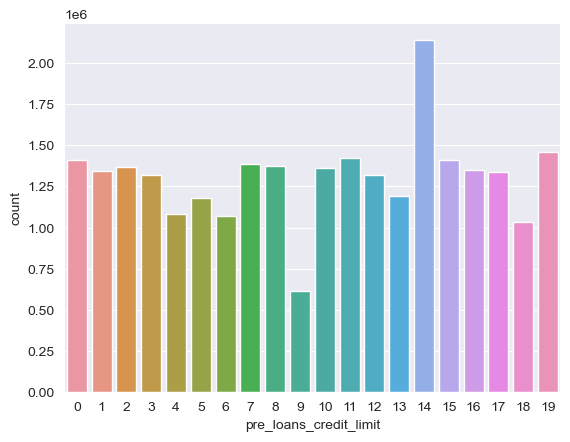

In [25]:
# pre_loans_credit_limit - Кредитный лимит (бинаризовано*)
sns.countplot(x='pre_loans_credit_limit', data=df);

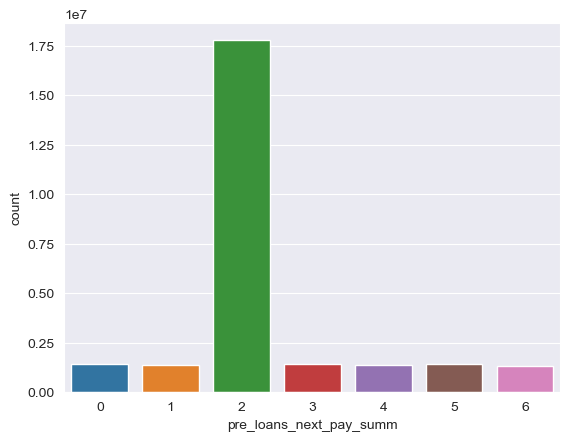

In [26]:
# pre_loans_next_pay_summ - Сумма следующего платежа по кредиту (бинаризовано*)
sns.countplot(x='pre_loans_next_pay_summ', data=df);

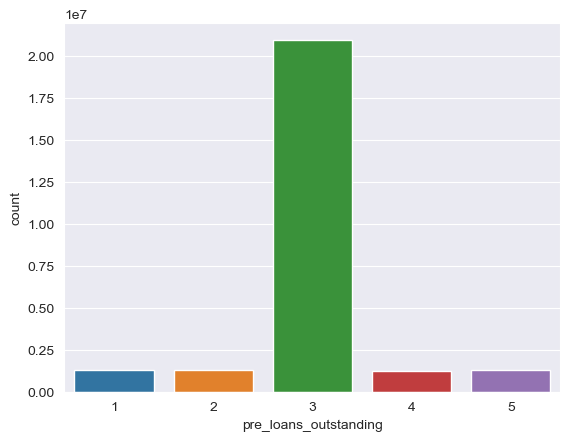

In [27]:
# pre_loans_outstanding - Оставшаяся невыплаченная сумма кредита (бинаризовано*)
sns.countplot(x='pre_loans_outstanding', data=df);

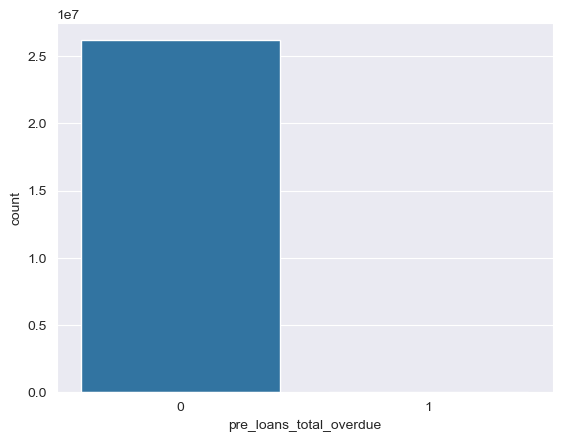

In [28]:
# pre_loans_total_overdue - Текущая просроченная задолженность (бинаризовано*)
sns.countplot(x='pre_loans_total_overdue', data=df);

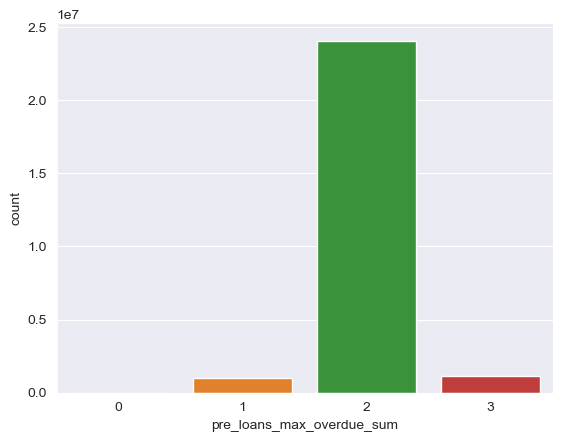

In [29]:
# pre_loans_max_overdue_sum - Максимальная просроченная задолженность (бинаризовано*)
sns.countplot(x='pre_loans_max_overdue_sum', data=df);

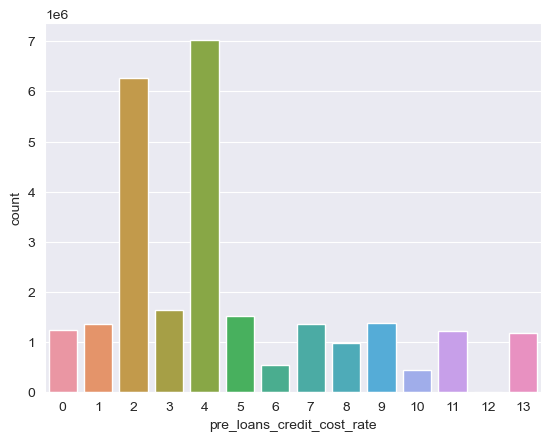

In [30]:
# pre_loans_credit_cost_rate - Полная стоимость кредита (бинаризовано*)
sns.countplot(x='pre_loans_credit_cost_rate', data=df);

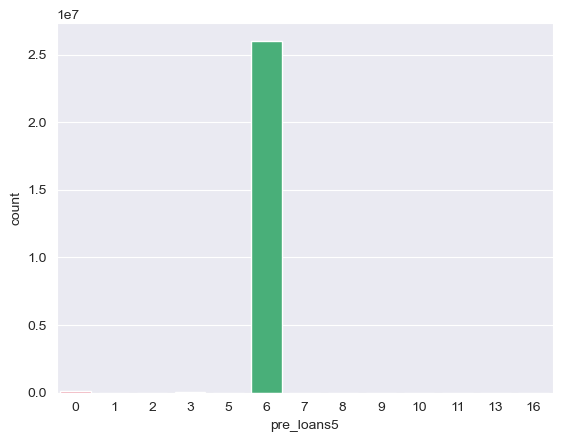

In [31]:
# pre_loans5 - Число просрочек до 5 дней (бинаризовано*)
sns.countplot(x='pre_loans5', data=df);

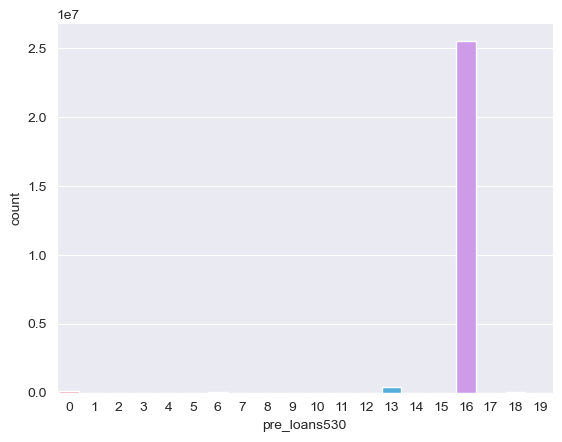

In [32]:
# pre_loans530 - Число просрочек от 5 до 30 дней (бинаризовано*)
sns.countplot(x='pre_loans530', data=df);

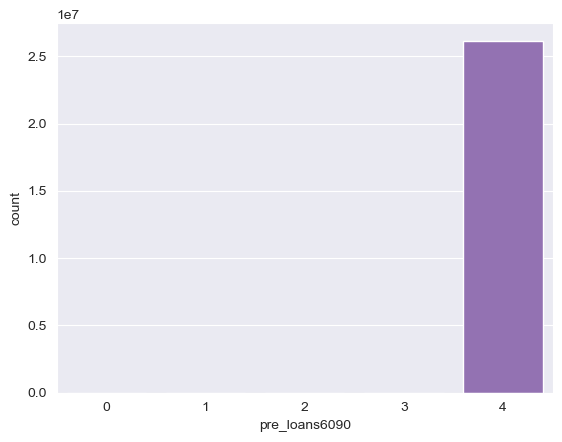

In [33]:
# pre_loans6090 - Число просрочек от 60 до 90 дней (бинаризовано*)
sns.countplot(x='pre_loans6090', data=df);

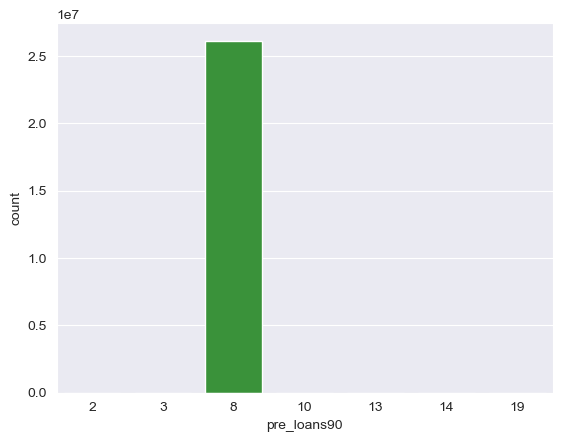

In [34]:
# pre_loans90	- Число просрочек более, чем на 90 дней (бинаризовано*)
sns.countplot(x='pre_loans90', data=df);

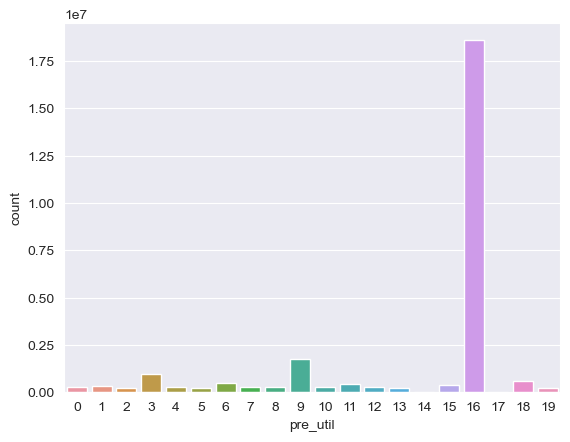

In [35]:
# pre_util - Отношение оставшейся невыплаченной суммы кредита к кредитному лимиту (бинаризовано*)
sns.countplot(x='pre_util', data=df);

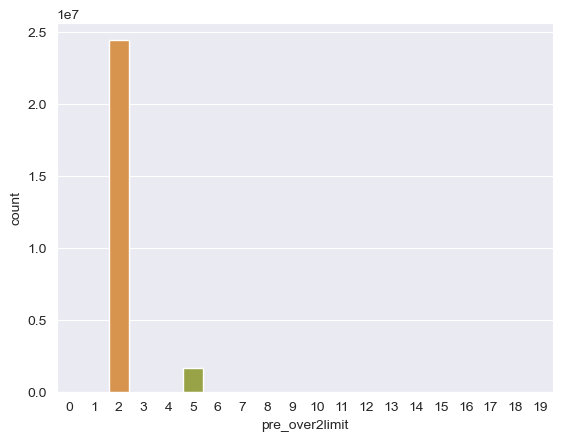

In [36]:
# pre_over2limit - Отношение текущей просроченной задолженности к кредитному лимиту (бинаризовано*)
sns.countplot(x='pre_over2limit', data=df);

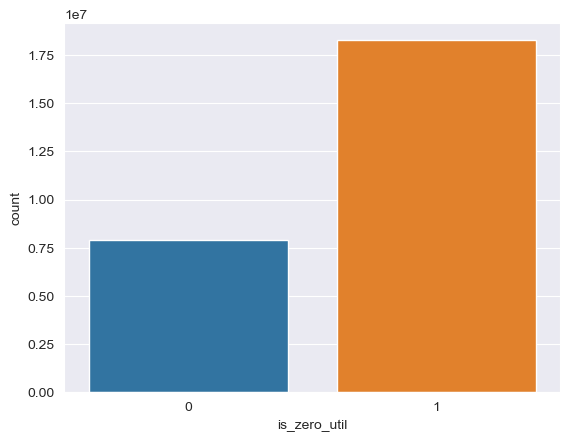

In [37]:
# is_zero_util - Флаг: отношение оставшейся невыплаченной суммы кредита к кредитному лимиту равняется 0
sns.countplot(x='is_zero_util', data=df);

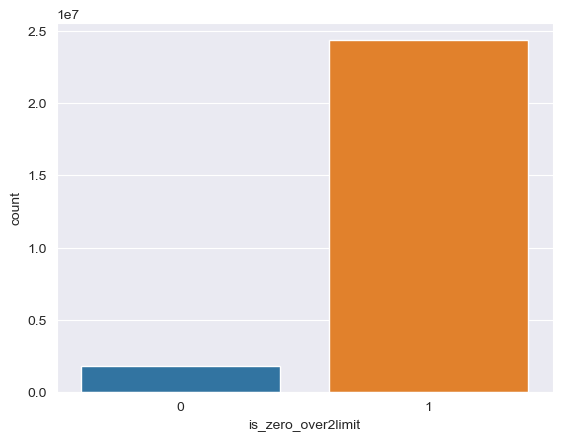

In [38]:
# is_zero_over2limit - Флаг: отношение текущей просроченной задолженности к кредитному лимиту равняется 0
sns.countplot(x='is_zero_over2limit', data=df);

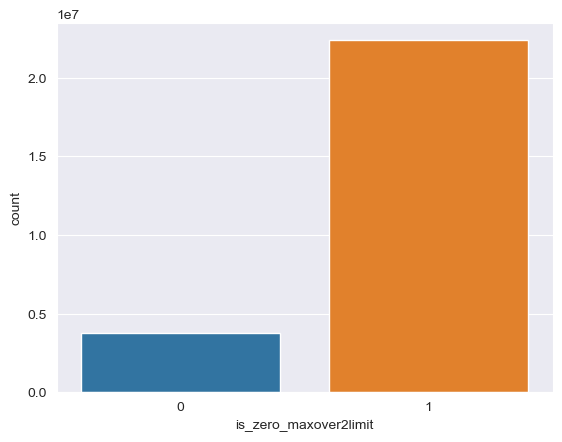

In [39]:
# is_zero_maxover2limit - Флаг: отношение максимальной просроченной задолженности к кредитному лимиту равняется 0
sns.countplot(x='is_zero_maxover2limit', data=df);

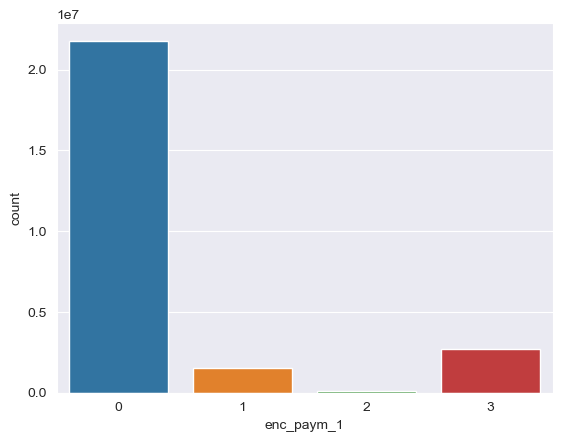

In [40]:
# enc_paym_{0..N} - Статусы ежемесячных платежей за последние N месяцев (закодировано**)
sns.countplot(x='enc_paym_1', data=df);

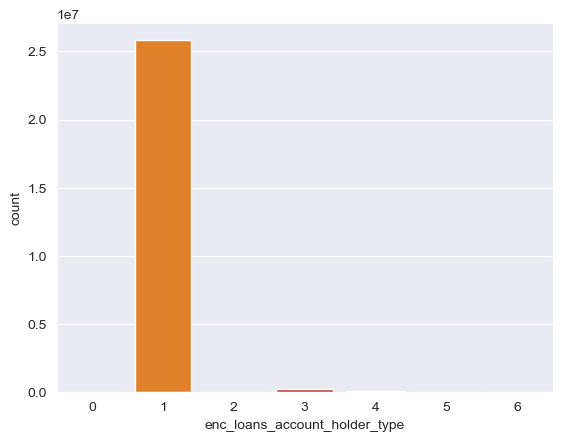

In [41]:
# enc_loans_account_holder_type - Тип отношения к кредиту (закодировано**)
sns.countplot(x='enc_loans_account_holder_type', data=df);

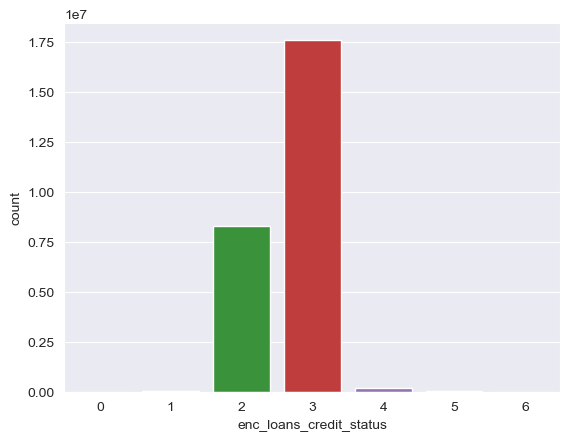

In [42]:
# enc_loans_credit_status	- Статус кредита (закодировано**)
sns.countplot(x='enc_loans_credit_status', data=df);

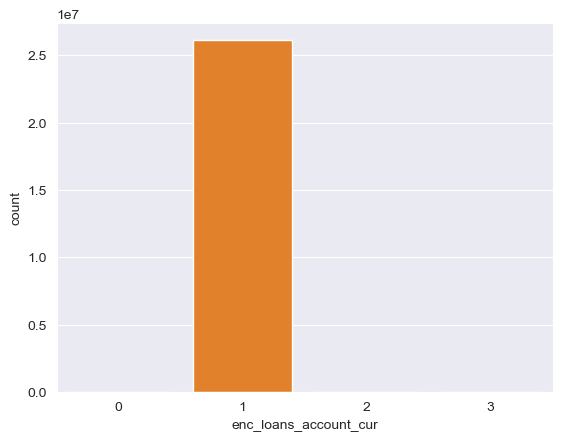

In [43]:
# enc_loans_account_cur - Валюта кредита (закодировано**)
sns.countplot(x='enc_loans_account_cur', data=df);

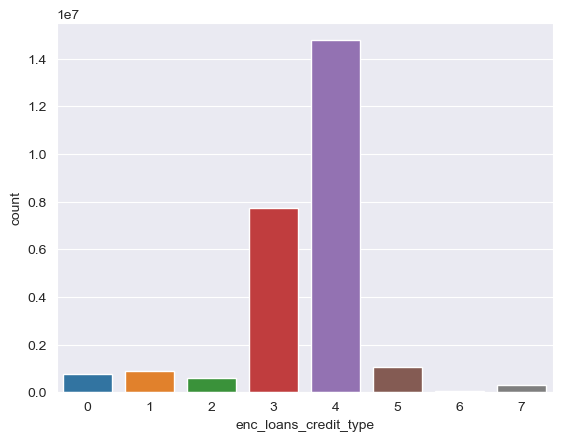

In [44]:
# enc_loans_credit_type - Тип кредита (закодировано**)
sns.countplot(x='enc_loans_credit_type', data=df);

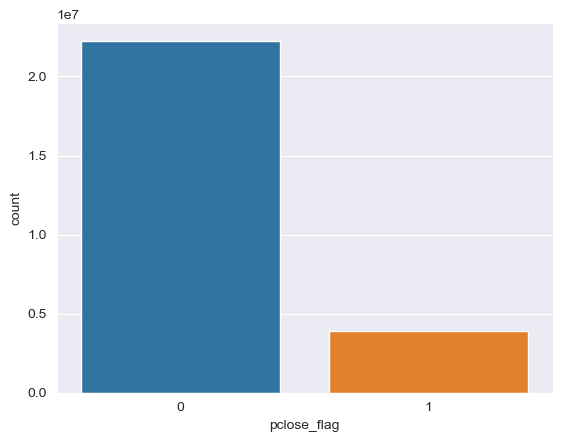

In [45]:
# pclose_flag - Флаг: плановое количество дней с даты открытия кредита до даты закрытия не определено
sns.countplot(x='pclose_flag', data=df);

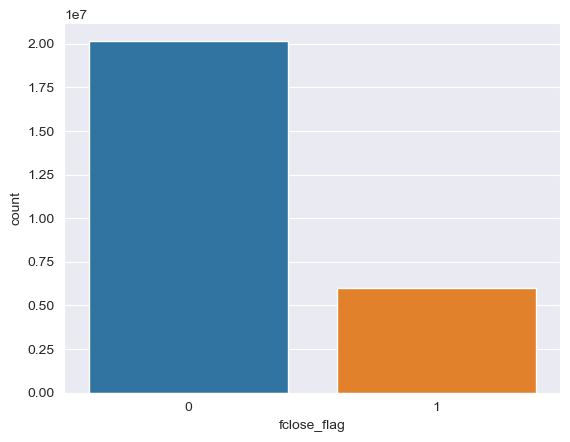

In [46]:
# fclose_flag - Флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено
sns.countplot(x='fclose_flag', data=df);

# Создание новых признаков

In [47]:
# Cумма флагов, указывающих на отсутствие просрочек
df['total_overdue_flags'] = (
        df['is_zero_loans5'] +
        df['is_zero_loans530'] +
        df['is_zero_loans3060'] +
        df['is_zero_loans6090'] +
        df['is_zero_loans90']
)

In [48]:
# Общее количество просрочек
df['total_overdue_counts'] = (
        df['pre_loans5'] +
        df['pre_loans530'] +
        df['pre_loans3060'] +
        df['pre_loans6090'] +
        df['pre_loans90']
)

In [49]:
# Длинна кредитной истории
df['credit_history_len'] = (
    df['pre_since_opened'] - 
    df['pre_since_confirmed']
)

In [50]:
# Разница между плановой и фактической датой открытия кредита
df['close_flags'] = (
    df['pclose_flag'] - 
    df['fclose_flag']
)

# Снижение размерности датасета 1

In [51]:
# Снизим размерность признаков датасета для уменьшения объема
col = df.columns
df[col] = df[col].apply(pd.to_numeric, downcast="integer")

In [52]:
#Нам удалось снизить размер датасета с 12 GB до 1.7 GB
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 66 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int32
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19

In [53]:
# Посмотрим описательные характеристики датасета
df.describe().round()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag,total_overdue_flags,total_overdue_counts,credit_history_len,close_flags
count,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0,26162717.0
mean,1545557.0,7.0,9.0,8.0,8.0,8.0,7.0,8.0,10.0,2.0,3.0,0.0,2.0,5.0,6.0,16.0,5.0,4.0,8.0,1.0,1.0,1.0,1.0,1.0,14.0,2.0,16.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0,5.0,39.0,1.0,-0.0
std,867988.0,5.0,6.0,5.0,5.0,4.0,5.0,4.0,6.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0
min,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,-17.0,-1.0
25%,794902.0,3.0,4.0,4.0,4.0,6.0,2.0,5.0,5.0,2.0,3.0,0.0,2.0,2.0,6.0,16.0,5.0,4.0,8.0,1.0,1.0,1.0,1.0,1.0,15.0,2.0,17.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0,4.0,39.0,-4.0,0.0
50%,1568512.0,6.0,9.0,9.0,8.0,8.0,7.0,10.0,10.0,2.0,3.0,0.0,2.0,4.0,6.0,16.0,5.0,4.0,8.0,1.0,1.0,1.0,1.0,1.0,16.0,2.0,17.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0,5.0,39.0,1.0,0.0
75%,2303681.0,10.0,14.0,12.0,14.0,12.0,12.0,11.0,15.0,2.0,3.0,0.0,2.0,7.0,6.0,16.0,5.0,4.0,8.0,1.0,1.0,1.0,1.0,1.0,16.0,2.0,17.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0,5.0,39.0,7.0,0.0
max,2999999.0,58.0,19.0,17.0,17.0,16.0,16.0,15.0,19.0,6.0,5.0,1.0,3.0,13.0,16.0,19.0,9.0,4.0,19.0,1.0,1.0,1.0,1.0,1.0,19.0,19.0,19.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,6.0,6.0,7.0,3.0,1.0,1.0,1.0,5.0,59.0,19.0,1.0


# Объединение признаков по id

In [54]:
# Создадим копию DataFrame, содержащая только столбцы 'id', 'rn' и 'flag'. 
prepared_df = df[['id', 'rn', 'flag']].copy()

In [55]:
# Найдем все столбцы в исходном DataFrame, кроме 'id', 'rn' и 'flag', и сохраняет их в списке features.
features = list(set(df.columns) - set(['id', 'rn', 'flag']))

In [56]:
# Здесь применяется функция pd.get_dummies для создания dummy (бинарных) признаков для всех категориальных переменных, указанных в features, путем одномерного кодирования
dummies = pd.get_dummies(df[features], columns=features)

In [57]:
# dummy-признаки добавляются к ранее подготовленному DataFrame, состоящему из столбцов 'id', 'rn' и 'flag'.
prepared_df = pd.concat([prepared_df, dummies], axis=1)

In [58]:
# Здесь создается словарь agg_df, в котором ключами являются имена признаков, для которых были созданы dummy-признаки (то есть все признаки, кроме 'id', 'rn' и 'flag'), а значениями — строка 'sum', которая указывает, что данные по этим признакам будут агрегированы с помощью суммы.
agg_df = {f: 'sum' for f in set(prepared_df.columns) - set(['id', 'rn', 'flag'])}

In [59]:
# Устанавливается, что для столбца 'rn' будет применена агрегирующая функция 'count', которая подсчитывает количество записей.
agg_df['rn'] = 'count'

In [60]:
# Выполняется группировка DataFrame по значениям столбцов 'id' и 'flag', к каждой группе применяется агрегирующая функция, заданная в agg_df.
# Затем результат преобразуется в целочисленный тип с помощью .astype('int').
# И наконец, индекс сбрасывается с помощью reset_index(drop=False), чтобы столбцы 'id' и 'flag' снова стали частью данных.
prepared_df = prepared_df.groupby(['id', 'flag']).agg(agg_df).astype('int').reset_index(drop=False)

In [61]:
prepared_df.head()

,id,flag,credit_history_len_12,pre_over2limit_8,pre_loans530_16,credit_history_len_-8,enc_paym_16_2,pre_fterm_11,pre_maxover2limit_10,total_overdue_counts_32,pre_since_confirmed_8,enc_paym_6_0,pre_till_fclose_13,enc_paym_24_2,pre_since_confirmed_13,pre_till_pclose_8,total_overdue_flags_5,pre_loans530_8,credit_history_len_17,total_overdue_counts_59,enc_paym_23_2,enc_paym_11_1,enc_paym_17_3,credit_history_len_7,pre_till_pclose_2,pre_till_fclose_14,pre_util_8,pre_maxover2limit_14,pre_since_opened_18,enc_paym_5_0,pre_maxover2limit_9,pre_over2limit_16,pre_util_4,pre_since_confirmed_2,pre_since_opened_10,pre_since_confirmed_5,credit_history_len_-4,pre_loans_credit_cost_rate_3,pre_loans_credit_limit_15,close_flags_-1,pre_loans6090_0,enc_paym_7_2,pre_maxover2limit_1,total_overdue_counts_28,enc_paym_16_0,pre_maxover2limit_5,pre_util_10,pre_fterm_16,enc_paym_1_1,total_overdue_flags_1,pre_loans530_18,pre_since_opened_3,enc_paym_14_0,pre_maxover2limit_2,pre_loans_total_overdue_1,pre_fterm_3,enc_paym_9_3,pre_loans_credit_limit_16,pre_pterm_4,total_overdue_counts_19,enc_paym_21_2,enc_paym_20_3,enc_paym_14_2,enc_paym_0_1,pre_till_pclose_9,pre_till_pclose_4,enc_paym_24_3,pre_loans5_7,enc_loans_account_cur_2,pre_since_opened_13,pre_till_pclose_1,pre_since_opened_2,is_zero_util_1,enc_paym_20_1,pre_pterm_6,credit_history_len_-13,pre_since_confirmed_10,pre_loans_credit_cost_rate_2,pre_loans90_10,pre_over2limit_14,enc_paym_3_1,pre_loans_credit_cost_rate_1,credit_history_len_-17,credit_history_len_18,pre_loans_credit_limit_12,pre_loans_credit_limit_19,enc_paym_15_3,enc_paym_23_3,pre_over2limit_4,pre_loans_credit_cost_rate_11,pre_util_2,pre_loans_outstanding_3,pre_loans90_14,pre_till_pclose_12,enc_paym_13_3,credit_history_len_-12,total_overdue_flags_4,pre_since_confirmed_14,pre_loans5_6,enc_paym_22_1,pre_till_fclose_5,pre_since_confirmed_12,total_overdue_counts_44,pre_loans90_2,pre_loans530_17,pre_loans_credit_limit_14,pre_util_5,pre_util_13,total_overdue_flags_3,pre_loans_credit_cost_rate_4,close_flags_0,is_zero_loans6090_0,pre_since_confirmed_1,enc_paym_8_0,pre_till_fclose_1,pre_loans_credit_limit_8,enc_paym_19_3,enc_paym_20_4,pre_fterm_9,pre_pterm_7,pre_till_fclose_12,total_overdue_counts_48,pre_since_opened_12,pre_till_fclose_11,pre_loans530_11,enc_paym_8_3,enc_paym_7_3,pre_loans_credit_limit_1,pre_loans530_10,pre_over2limit_2,enc_paym_0_0,enc_paym_11_4,enc_loans_account_holder_type_4,pclose_flag_1,credit_history_len_5,pre_loans5_5,pre_loans_credit_cost_rate_0,credit_history_len_15,pre_till_fclose_3,pre_loans6090_2,enc_loans_credit_type_7,enc_paym_4_3,pre_loans5_13,pre_loans_max_overdue_sum_1,pre_loans5_11,fclose_flag_1,enc_paym_13_0,pre_loans530_0,pre_pterm_8,enc_paym_12_0,pre_till_fclose_0,credit_history_len_16,pre_loans_credit_limit_13,enc_paym_6_3,pre_till_pclose_11,pre_fterm_4,pre_since_opened_9,pre_loans_credit_cost_rate_9,pre_since_opened_16,enc_paym_22_3,pre_since_opened_7,pre_since_confirmed_6,enc_paym_4_2,credit_history_len_2,pre_loans_credit_limit_17,pre_over2limit_18,enc_paym_16_3,credit_history_len_-7,pre_loans530_6,pre_loans5_3,pre_over2limit_10,pre_util_9,pre_loans_credit_limit_11,enc_paym_0_3,enc_paym_12_1,pre_since_confirmed_7,pre_till_pclose_16,enc_paym_10_2,total_overdue_counts_55,pre_since_opened_0,enc_paym_18_1,enc_paym_3_2,enc_paym_15_2,total_overdue_flags_2,pre_loans_next_pay_summ_5,pre_loans_max_overdue_sum_0,enc_loans_account_cur_1,pre_fterm_1,pre_till_fclose_9,pre_loans530_13,credit_history_len_-5,pre_loans530_19,total_overdue_counts_39,pre_loans_outstanding_4,pclose_flag_0,pre_loans_credit_cost_rate_10,enc_loans_credit_status_3,enc_paym_7_0,enc_paym_17_2,pre_maxover2limit_13,pre_loans530_1,credit_history_len_-6,pre_util_15,pre_pterm_3,pre_till_fclose_2,pre_fterm_2,total_overdue_counts_54,pre_since_opened_5,pre_since_opened_1,total_overdue_counts_49,pre_since_confirmed_11,pre_fterm_0,enc_paym_15_1,pre_loans_max_overdue_sum_3,pre_over2limit_19,pre_util_1,enc_paym_11_3,pre_fterm_7,close_flags_1,credit_history_len_10,pre_l

In [62]:
agg_df = prepared_df

# Удаление неинформативных признаков и признаков с одним значением

In [63]:
# Определим признаки с одним значением
single_valued_columns = agg_df.columns[agg_df.nunique() == 1]

In [64]:
# Удалим признаки с одним значением из датасета
agg_df = agg_df.drop(single_valued_columns, axis=1)

In [65]:
agg_df.shape

(3000000, 510)

# Масштабирование признаков

In [66]:
# Здесь создается список binary_features, который содержит все столбцы из agg_df, имеющие ровно два уникальных значения. Это обычно признаки, которые принимают значения 0 и 1 (бинарные).
binary_features = [col for col in agg_df.columns if agg_df[col].nunique() == 2]

In [67]:
# Создается список continuous_features, который включает все столбцы из agg_df, кроме бинарных признаков, а также столбцов 'id' и 'flag'.
continuous_features = [col for col in agg_df.columns if col not in binary_features and col not in ['flag', 'id']]

In [68]:
scaler = StandardScaler()

In [69]:
agg_df[continuous_features] = scaler.fit_transform(agg_df[continuous_features])

In [70]:
# Удаляем столбец id, если он присутствует
if 'id' in agg_df.columns:
    agg_df.drop('id', axis=1, inplace=True)

In [71]:
# Проверяем на дублирование столбца flag 
if 'flag' not in agg_df.columns:
    agg_df['flag'] = flag

In [72]:
# Итоговый DataFrame
scaled_df = agg_df.copy()

In [73]:
scaled_df.head()

,flag,credit_history_len_12,pre_over2limit_8,pre_loans530_16,credit_history_len_-8,enc_paym_16_2,pre_fterm_11,pre_maxover2limit_10,total_overdue_counts_32,pre_since_confirmed_8,enc_paym_6_0,pre_till_fclose_13,enc_paym_24_2,pre_since_confirmed_13,pre_till_pclose_8,total_overdue_flags_5,pre_loans530_8,credit_history_len_17,total_overdue_counts_59,enc_paym_23_2,enc_paym_11_1,enc_paym_17_3,credit_history_len_7,pre_till_pclose_2,pre_till_fclose_14,pre_util_8,pre_maxover2limit_14,pre_since_opened_18,enc_paym_5_0,pre_maxover2limit_9,pre_over2limit_16,pre_util_4,pre_since_confirmed_2,pre_since_opened_10,pre_since_confirmed_5,credit_history_len_-4,pre_loans_credit_cost_rate_3,pre_loans_credit_limit_15,close_flags_-1,pre_loans6090_0,enc_paym_7_2,pre_maxover2limit_1,total_overdue_counts_28,enc_paym_16_0,pre_maxover2limit_5,pre_util_10,pre_fterm_16,enc_paym_1_1,total_overdue_flags_1,pre_loans530_18,pre_since_opened_3,enc_paym_14_0,pre_maxover2limit_2,pre_loans_total_overdue_1,pre_fterm_3,enc_paym_9_3,pre_loans_credit_limit_16,pre_pterm_4,total_overdue_counts_19,enc_paym_21_2,enc_paym_20_3,enc_paym_14_2,enc_paym_0_1,pre_till_pclose_9,pre_till_pclose_4,enc_paym_24_3,pre_loans5_7,enc_loans_account_cur_2,pre_since_opened_13,pre_till_pclose_1,pre_since_opened_2,is_zero_util_1,enc_paym_20_1,pre_pterm_6,credit_history_len_-13,pre_since_confirmed_10,pre_loans_credit_cost_rate_2,pre_loans90_10,pre_over2limit_14,enc_paym_3_1,pre_loans_credit_cost_rate_1,credit_history_len_-17,credit_history_len_18,pre_loans_credit_limit_12,pre_loans_credit_limit_19,enc_paym_15_3,enc_paym_23_3,pre_over2limit_4,pre_loans_credit_cost_rate_11,pre_util_2,pre_loans_outstanding_3,pre_loans90_14,pre_till_pclose_12,enc_paym_13_3,credit_history_len_-12,total_overdue_flags_4,pre_since_confirmed_14,pre_loans5_6,enc_paym_22_1,pre_till_fclose_5,pre_since_confirmed_12,total_overdue_counts_44,pre_loans90_2,pre_loans530_17,pre_loans_credit_limit_14,pre_util_5,pre_util_13,total_overdue_flags_3,pre_loans_credit_cost_rate_4,close_flags_0,is_zero_loans6090_0,pre_since_confirmed_1,enc_paym_8_0,pre_till_fclose_1,pre_loans_credit_limit_8,enc_paym_19_3,enc_paym_20_4,pre_fterm_9,pre_pterm_7,pre_till_fclose_12,total_overdue_counts_48,pre_since_opened_12,pre_till_fclose_11,pre_loans530_11,enc_paym_8_3,enc_paym_7_3,pre_loans_credit_limit_1,pre_loans530_10,pre_over2limit_2,enc_paym_0_0,enc_paym_11_4,enc_loans_account_holder_type_4,pclose_flag_1,credit_history_len_5,pre_loans5_5,pre_loans_credit_cost_rate_0,credit_history_len_15,pre_till_fclose_3,pre_loans6090_2,enc_loans_credit_type_7,enc_paym_4_3,pre_loans5_13,pre_loans_max_overdue_sum_1,pre_loans5_11,fclose_flag_1,enc_paym_13_0,pre_loans530_0,pre_pterm_8,enc_paym_12_0,pre_till_fclose_0,credit_history_len_16,pre_loans_credit_limit_13,enc_paym_6_3,pre_till_pclose_11,pre_fterm_4,pre_since_opened_9,pre_loans_credit_cost_rate_9,pre_since_opened_16,enc_paym_22_3,pre_since_opened_7,pre_since_confirmed_6,enc_paym_4_2,credit_history_len_2,pre_loans_credit_limit_17,pre_over2limit_18,enc_paym_16_3,credit_history_len_-7,pre_loans530_6,pre_loans5_3,pre_over2limit_10,pre_util_9,pre_loans_credit_limit_11,enc_paym_0_3,enc_paym_12_1,pre_since_confirmed_7,pre_till_pclose_16,enc_paym_10_2,total_overdue_counts_55,pre_since_opened_0,enc_paym_18_1,enc_paym_3_2,enc_paym_15_2,total_overdue_flags_2,pre_loans_next_pay_summ_5,pre_loans_max_overdue_sum_0,enc_loans_account_cur_1,pre_fterm_1,pre_till_fclose_9,pre_loans530_13,credit_history_len_-5,pre_loans530_19,total_overdue_counts_39,pre_loans_outstanding_4,pclose_flag_0,pre_loans_credit_cost_rate_10,enc_loans_credit_status_3,enc_paym_7_0,enc_paym_17_2,pre_maxover2limit_13,pre_loans530_1,credit_history_len_-6,pre_util_15,pre_pterm_3,pre_till_fclose_2,pre_fterm_2,total_overdue_counts_54,pre_since_opened_5,pre_since_opened_1,total_overdue_counts_49,pre_since_confirmed_11,pre_fterm_0,enc_paym_15_1,pre_loans_max_overdue_sum_3,pre_over2limit_19,pre_util_1,enc_paym_11_3,pre_fterm_7,close_flags_1,credit_history_len_10,pre_loan

In [74]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 509 entries, flag to rn
dtypes: float64(468), int32(40), int8(1)
memory usage: 10.9 GB


# Снижение размерности датасета 2

In [75]:
# Приведение к целочисленным типам минимального размера:
scaled_df = scaled_df.apply(pd.to_numeric, downcast='integer')

In [76]:
# Приведение к вещественным типам минимального размера
scaled_df = scaled_df.apply(pd.to_numeric, downcast='float')

In [77]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 509 entries, flag to rn
dtypes: float32(468), int8(41)
memory usage: 5.3 GB


# Разделение на тестовую и тренировочную выборки

In [78]:
X = scaled_df.drop(columns=['flag'], axis=1)
y = scaled_df['flag']

In [79]:
X.columns = X.columns.str.replace("-", "x")

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 508 entries, credit_history_len_12 to rn
dtypes: float32(468), int8(40)
memory usage: 5.3 GB


In [81]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000000 entries, 0 to 2999999
Series name: flag
Non-Null Count    Dtype
--------------    -----
3000000 non-null  int8 
dtypes: int8(1)
memory usage: 2.9 MB


In [82]:
# Разделение данных на обучающую и тестовую выборки
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state=42, stratify=y)

# Моделирование

In [83]:
# Рассчитываем веса образцов
sample_weights = compute_sample_weight(class_weight='balanced', y=train_y)

In [84]:
xgbc = XGBClassifier(learning_rate=0.2, n_estimators=400, max_depth=3)

In [85]:
# Обучаем XGBoost классификатор
xgbc.fit(train_x, train_y, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
# Оценка модели
y_pred = xgbc.predict(test_x)
y_pred_proba = xgbc.predict_proba(test_x)[:, 1]
print(f"AUC-ROC: {roc_auc_score(test_y, y_pred_proba)}")
print(classification_report(test_y, y_pred))

AUC-ROC: 0.758312385302641
              precision    recall  f1-score   support

           0       0.98      0.68      0.81    578712
           1       0.07      0.70      0.14     21288

    accuracy                           0.68    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.68      0.78    600000



In [87]:
# 1. Высокая AUC-ROC указывает на то, что модель хорошо умеет различать классы в целом.

In [88]:
# 2. Precision для высокого риска очень низкая (0.07), что означает, что модель часто ошибается при предсказании высокорисковых заемщиков (много false positives).

In [89]:
# 3. Recall для высокого риска довольно высокое (0.70), что означает, что модель находит большинство высокорисковых заемщиков (немного ошибается, не предсказывая их).
# Думаю это наиболее важный показатель.

In [90]:
# 4. Для низкорисковых заемщиков модель показывает очень хорошие precision (0.98), что означает, что почти все предсказания низкого риска являются правильными, но средний recall (0.68) указывает, что многие низкорисковые заемщики были упущены.

# Порог предсказания вероятности

In [91]:
# Предсказание вероятностей для каждого класса
y_proba = xgbc.predict_proba(test_x)
y_true = test_y

In [92]:
# Функция для получения метрик на разных порогах
def evaluate_thresholds(y_true, y_proba):
    thresholds = np.arange(0.0, 1.1, 0.1)
    for threshold in thresholds:
        y_pred = np.where(y_proba[:, 1] >= threshold, 1, 0)
        print(f"Threshold: {threshold:.1f}")
        print(classification_report(y_true, y_pred))
        print("--------------------------------")

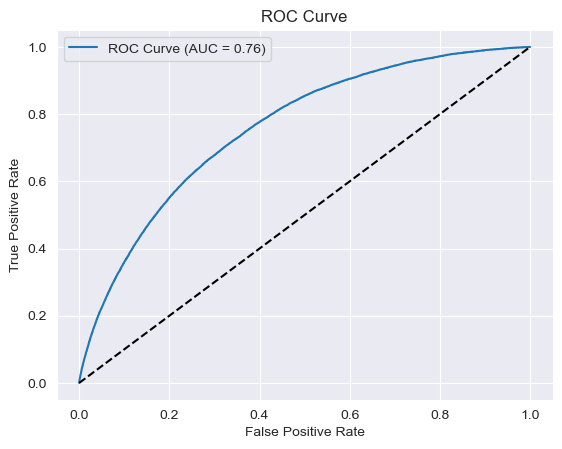

In [93]:
# Визуализация ROC-кривой и выбор порога
fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_true, y_proba[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

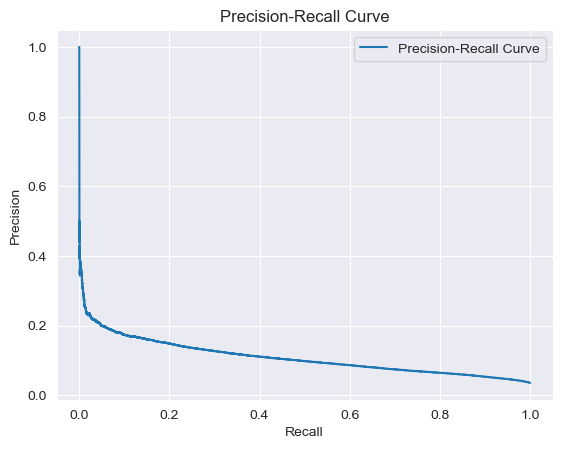

In [94]:
# Визуализация Precision-Recall-кривой
precision, recall, thresholds = precision_recall_curve(y_true, y_proba[:, 1])
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [95]:
# Оценка метрик для различных порогов
evaluate_thresholds(y_true, y_proba)

Threshold: 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    578712
           1       0.04      1.00      0.07     21288

    accuracy                           0.04    600000
   macro avg       0.02      0.50      0.03    600000
weighted avg       0.00      0.04      0.00    600000

--------------------------------
Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.04      0.08    578712
           1       0.04      1.00      0.07     21288

    accuracy                           0.08    600000
   macro avg       0.52      0.52      0.08    600000
weighted avg       0.96      0.08      0.08    600000

--------------------------------
Threshold: 0.2
              precision    recall  f1-score   support

           0       0.99      0.20      0.34    578712
           1       0.04      0.97      0.08     21288

    accuracy                           0.23    600000
   macro avg     

In [96]:
# При пороге 0.5 модель дает относительно высокую точность для класса 0 (98%), а также имеет приемлемый recall (70%) для класса 1.

# Обучение модели на всех данных

In [97]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

In [98]:
xgbc.fit(X, y, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [99]:
# Оценка модели
y_pred = xgbc.predict(X)
y_pred_proba = xgbc.predict_proba(X)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y, y_pred_proba)}")
print(classification_report(y, y_pred))

AUC-ROC: 0.7694128556697746
              precision    recall  f1-score   support

           0       0.98      0.68      0.81   2893558
           1       0.08      0.72      0.14    106442

    accuracy                           0.69   3000000
   macro avg       0.53      0.70      0.47   3000000
weighted avg       0.95      0.69      0.78   3000000



In [ ]:
# Сохранение оценок модели

In [101]:
predictions_df = pd.DataFrame({
    'id': prepared_df['id'],
    'pred': y_pred
})

In [104]:
predictions_path = os.path.join('G://ds-junior/final_work_ds/predictions', 'predictions.csv')
predictions_df.to_csv(predictions_path, index=False)

In [105]:
predictions_df.head()

,id,pred
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
